<div style="border: 2px solid blue; padding: 5px; color: red; text-align: center; font-size: 24px;">
 EMBEDDINGS COMPARAISON
</div>

The aim of this notebook is to compare different types of embedding. We will compare 3 embeddings:

1. PointWise Mutual information
2. Co-occurence matrix
3. Skip-gram

# 1. Librairies

In [2]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
# Style use.
sns.set_style('darkgrid')

# 2. Data

In [3]:
df = pd.read_csv("paris-2024-faq.csv", sep=";")
print(df.shape)
df.head()

(1091, 6)


,id,lang,label,body,topics,url
0,50G4-9Wz-fr,fr,Est-il toujours possible de candidater aux Cen...,"Désormais, il n’est plus possible de proposer ...",Autres;Terre de Jeux;Programmes Paris 2024,https://help.paris2024.org/contents/Est-il-tou...
1,6EFUb0FA-fr,fr,Paris 2024 propose-t-il une solution d’héberge...,Paris 2024 n’a pas vocation à proposer de solu...,Autres;Terre de Jeux;TDJ - Volontaire,https://help.paris2024.org/contents/Paris-2024...
2,FVASOtOh-fr,fr,Qu'est-ce que l'album Panini Équipe de France ?,"Le 2 avril 2024, pour célébrer son 50ᵉ anniver...",Sports et Athlètes;Athlètes;Équipe de France,https://help.paris2024.org/contents/Qu-est-ce-...
3,IN6et_ZX-fr,fr,"Qu'est-ce que la campagne ""Rendez-vous avec l'...","""Rendez-vous avec l'histoire"" est la campagne ...",Sports et Athlètes;Athlètes;Équipe de France,https://help.paris2024.org/contents/Qu-est-ce-...
4,aHSSm1RL-fr,fr,Politique de confidentialité Paris 2024,Version en ligne : 24/06/2024\n\nLe COMITE D'O...,Autres;Comptes et données personnelles,https://help.paris2024.org/contents/Politique-...


In [4]:
eng_df = df[df["lang"] == "en"]
print(eng_df.shape)
eng_df.head()

(548, 6)


,id,lang,label,body,topics,url
180,OnhGUi82-en,en,Is it possible to receive goodies for our end-...,Paris 2024 does not distribute goodies outside...,Labels;Generation 2024;Support,https://help.paris2024.org/en-gb/contents/Is-i...
181,OngJLw_h-en,en,Who can claim to carry the Flame?,Paris 2024 aims to make the Torch Relay a repr...,Sports and events;Relay of the Flame;The beare...,https://help.paris2024.org/en-gb/contents/Who-...
182,_YSeI5vz-en,en,What are the parking options for residents liv...,Residents residing inside a security perimeter...,Practical informations;Impacts of Games;Ile-de...,https://help.paris2024.org/en-gb/contents/What...
183,6aqKEF-0-en,en,How to purchase the official mascot of Paris 2...,The Paris 2024 mascots are available on the of...,Other;Terre de Jeux;Terre de Jeux 2024 shop,https://help.paris2024.org/en-gb/contents/How-...
184,Bo1p4ZX3-en,en,What is the territorial ticketing?,Unprecedented in the history of the Olympic an...,Other;Terre de Jeux;Territorial Ticketing,https://help.paris2024.org/en-gb/contents/What...


# 3. Embeddings

In [5]:
responses = eng_df["body"].tolist()

In [8]:
def preprocess_comments(comments):
    cleaned_comments = []
    for comment in comments:
        comment = re.sub(r'http\S+', '', comment)  # Remove URLs
        comment = re.sub(r'[^A-Za-z0-9\s]+', '', comment)  # Remove special characters
        comment = comment.lower()  # Convert to lowercase
        #comment = ' '.join([word for word in comment.split() if word not in stop_words])  # Remove stop words
        cleaned_comments.append(comment)
    return cleaned_comments

In [9]:
preprocess_responses = preprocess_comments(responses)

In [10]:
# Tokenize the corpus
sentence_tokens = [sentence.split() for sentence in preprocess_responses]
tokens = [token for sentence in sentence_tokens for token in sentence]
tokens[:5]


['paris', '2024', 'does', 'not', 'distribute']

In [11]:
# Create a vocabulary
vocab = set(tokens)
vocab = {word: idx for idx, word in enumerate(vocab)}
print(f"The len of the vocabulary is {len(vocab)}.")

The len of the vocabulary is 4647.


## 3.1 Co-occurence Matrix

In [12]:
co_occurrence_matrix = np.zeros((len(vocab), len(vocab)))

In [13]:
window_size = 5
co_occurrence_matrix = np.zeros((len(vocab), len(vocab)))
# Populate the co-occurrence matrix
for sentence in sentence_tokens:
    n = len(sentence)
    for i in range(n):
        word_idx = vocab[sentence[i]]
        for j in range(n):
            context_word_idx = vocab[sentence[j]]
            co_occurrence_matrix[word_idx, context_word_idx] += 1

In [14]:
#normalize embedidngs
co_occurrence_matrix_norm = co_occurrence_matrix/ np.sum(co_occurrence_matrix, axis=1, keepdims=True)

In [15]:
# Reduce the dimensionality of the co-occurrence matrix
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2)
embeddings = svd.fit_transform(co_occurrence_matrix_norm)

In [16]:
# Plot the word embeddings
words = ['committee','athletes','opening','ceremony',"france", "usa", "game", "games", "sports", "sport", "olympics", "olympic", "paris", '2024', 'paralympic', "french"]
word_indices = [vocab[word] for word in words]
word_embeddings = embeddings[word_indices]


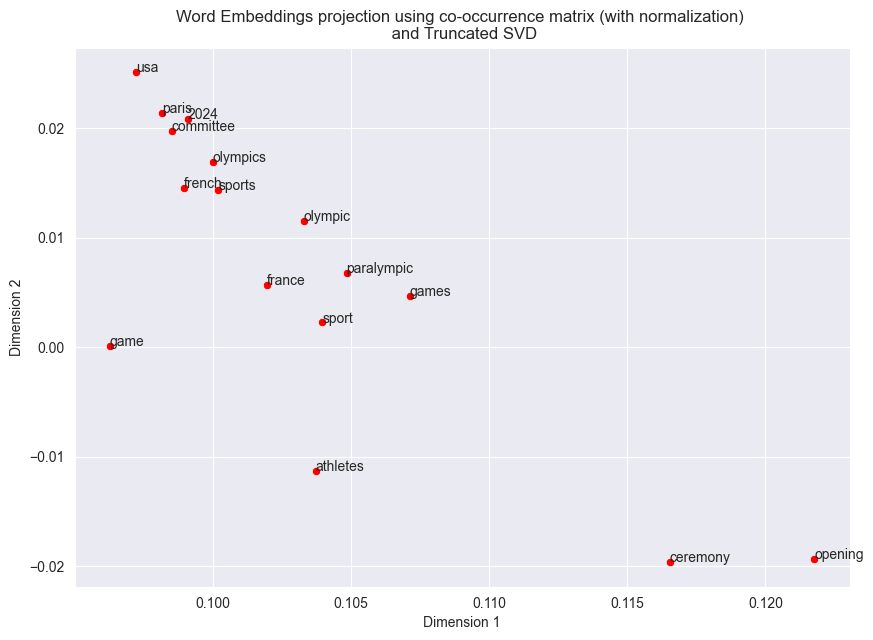

In [17]:
#nuage de point
plt.figure(figsize=(10, 7))
sns.scatterplot(x=word_embeddings[:, 0], y=word_embeddings[:, 1], c='r')
for i, word in enumerate(words):
    plt.text(word_embeddings[i, 0], word_embeddings[i, 1], word)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("Word Embeddings projection using co-occurrence matrix (with normalization) \n and Truncated SVD")
plt.savefig("word_embeddings_coom.png")
plt.show()

## 3.2 PointWise Mutual Information

In [176]:
def calculate_pmi(co_occurrence_matrix, word_counts, total_count):
    pmi_matrix = np.zeros_like(co_occurrence_matrix, dtype=float)
    for i in range(co_occurrence_matrix.shape[0]):
        for j in range(co_occurrence_matrix.shape[1]):
            p_w_c = co_occurrence_matrix[i, j] / total_count
            p_w = word_counts[i] / total_count
            p_c = word_counts[j] / total_count
            if p_w_c > 0:
                pmi_matrix[i, j] = np.log(p_w_c / (p_w * p_c))
    return pmi_matrix

In [177]:
def calculate_pmi(co_occurrence_matrix, word_counts, total_count):
    pmi_matrix = np.zeros_like(co_occurrence_matrix, dtype=float)
    for i in range(co_occurrence_matrix.shape[0]):
        for j in range(co_occurrence_matrix.shape[1]):
            p_w_c = co_occurrence_matrix[i, j] / total_count
            p_w = word_counts[i] / total_count
            p_c = word_counts[j] / total_count
            if p_w_c > 0:
                pmi_matrix[i, j] = np.log(p_w_c / (p_w * p_c))
    return pmi_matrix

def create_co_occurrence_matrix(corpus, vocab, window_size=2):
    vocab_size = len(vocab)
    co_occurrence_matrix = np.zeros((vocab_size, vocab_size), dtype=int)
    word_counts = Counter()
    for words in corpus:
        #words = sentence.split()
        for i, word in enumerate(words):
            if word in vocab:
                word_counts[vocab[word]] += 1
                context = words[max(0, i - window_size):i] + words[i + 1:i + 1 + window_size]
                for context_word in context:
                    if context_word in vocab:
                        co_occurrence_matrix[vocab[word], vocab[context_word]] += 1
    return co_occurrence_matrix, word_counts





In [178]:
co_occurrence_matrix, word_counts = create_co_occurrence_matrix(sentence_tokens, vocab)

In [179]:
total_count = sum(word_counts.values())
pmi_matrix = calculate_pmi(co_occurrence_matrix, word_counts, total_count)

In [180]:
svd2 = TruncatedSVD(n_components=2)
embeddings_pmi = svd2.fit_transform(pmi_matrix)

In [181]:
word_indices = [vocab[word] for word in words]
word_embeddings = embeddings_pmi[word_indices]

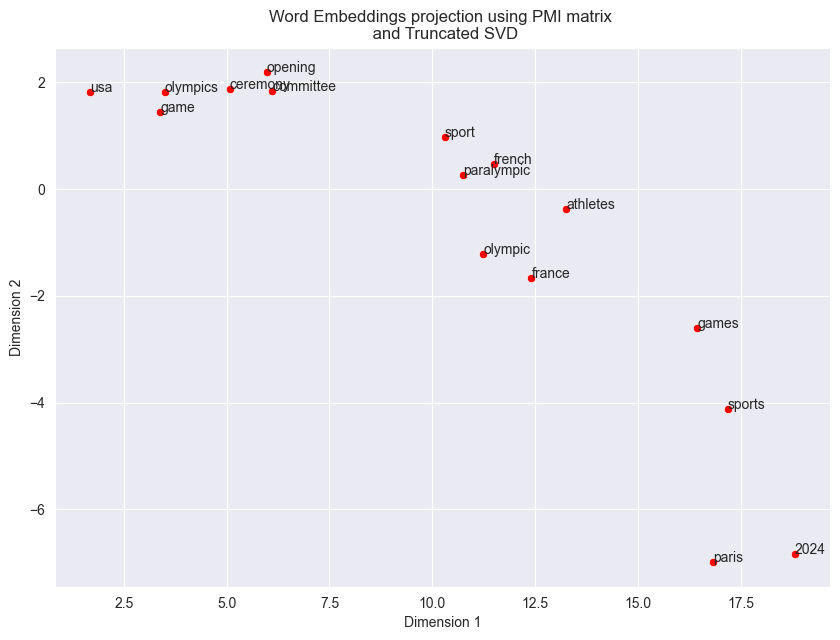

In [182]:
#nuage de point
plt.figure(figsize=(10, 7))
sns.scatterplot(x=word_embeddings[:, 0], y=word_embeddings[:, 1], c='r')
for i, word in enumerate(words):
    plt.text(word_embeddings[i, 0], word_embeddings[i, 1], word)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("Word Embeddings projection using PMI matrix \n and Truncated SVD")
plt.savefig("word_embeddings_pmi.png")
plt.show()

## 3.3 Skipgram

In [183]:
from gensim.models import Word2Vec

In [215]:
model = Word2Vec(sentences=sentence_tokens, vector_size=100, window=2, sg=1, min_count=1)

In [216]:
word_vectors = [model.wv[word] for word in model.wv.index_to_key]
print(len(word_vectors))

4647


In [217]:
svd3 = TruncatedSVD(n_components=2)
embeddings_w2v = svd3.fit_transform(word_vectors)

In [218]:
words_index = [model.wv.index_to_key.index(word) for word in words]

In [219]:
word_embeddings = embeddings_w2v[words_index]

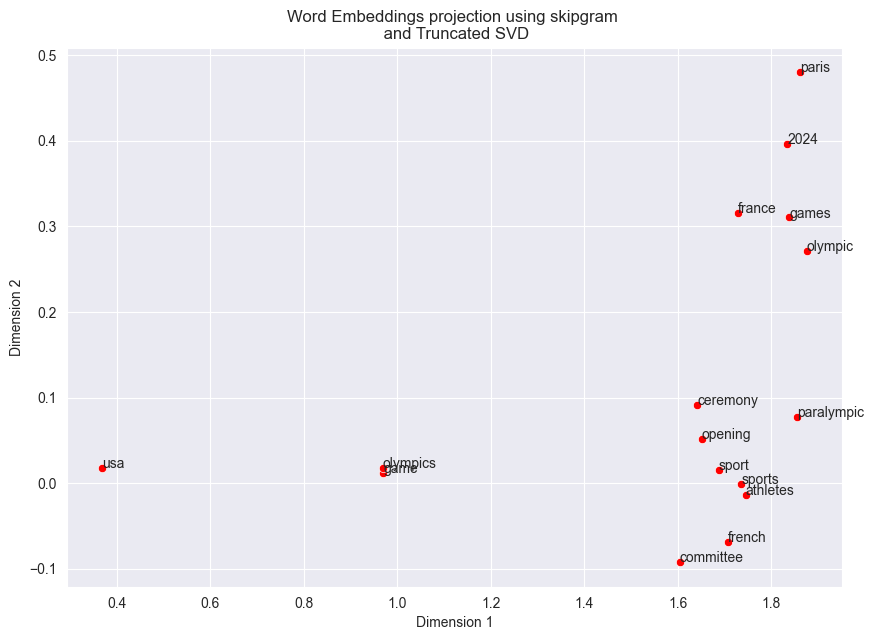

In [220]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x=word_embeddings[:, 0], y=word_embeddings[:, 1], c='r')
for i, word in enumerate(words):
    plt.text(word_embeddings[i, 0], word_embeddings[i, 1], word)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("Word Embeddings projection using skipgram \n and Truncated SVD")
plt.savefig("word_embeddings_skipgram.png")
plt.show()